# LTSM Model Development and Evaluation for Event Sequence Monitoring

## Introduction
This notebook explores the development and evaluation of a LTSM (Long Term Short Memory) model for event sequence monitoring in the TVM (Total Minutes Viewed) ETL (Extract, Transform, Load) process. The goal is to detect out-of-sequence events, which could have an impact on partner and product reporting.

## Data Preprocessing
The notebook begins with data preprocessing steps, including reading the event log data from a CSV file, converting timestamps to datetime objects, sorting the data based on event occurrence time, and dropping irrelevant columns like 'HIT_ID'. It also converts datetime features into Unix timestamps and handles missing values using SimpleImputer.

## Sequencing Rules and Event Marking
Sequencing rules are defined to determine the sequence of events based on specific criteria. Functions are created to mark events as in or out of sequence based on time differences between consecutive events.

## Model Development and Training
The LTSM model is built using the Keras library. The notebook defines the architecture of the LTSM model with masking layers to handle variable-length input sequences. It compiles the model with appropriate loss and optimization functions and trains it using historical event sequences.

## Model Evaluation
The trained LTSM model is evaluated on a test dataset to assess its performance in detecting out-of-sequence events. The evaluation metrics include loss and accuracy.

## Results
The LTSM model achieves a certain level of accuracy and loss on the test dataset, indicating its effectiveness in monitoring event sequences in the TVM ETL process.

## Conclusion
The notebook demonstrates the development, training, and evaluation of a LTSM model for event sequence monitoring. It provides insights into the performance of the model and its potential application in real-time monitoring systems.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking

# Define File Path
file_path = "/Users/krista.rime/Documents/AIML/capstone_project.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

In [2]:
# Convert 'EVENT_OCCURRED_UTC' to datetime
df['EVENT_OCCURRED_UTC'] = pd.to_datetime(df['EVENT_OCCURRED_UTC'])

# Sort DataFrame based on 'EVENT_OCCURRED_UTC'
df.sort_values(by='EVENT_OCCURRED_UTC', inplace=True)

# Reset index
df.reset_index(drop=True, inplace=True)

# Drop the 'HIT_ID'
if 'HIT_ID' in df.columns:
    df.drop(columns=['HIT_ID'], inplace=True)

# Convert 'EVENT_OCCURRED_UTC' to Unix timestamps
df['EVENT_OCCURRED_UNIX'] = df['EVENT_OCCURRED_UTC'].apply(lambda x: x.timestamp())

# Define X
X = df.copy()

In [3]:
# Preprocess the Data
# Define datetime features and numerical features
sequences = df.groupby(['CLIENT_ID', 'SESSION_ID'])
datetime_features = df.select_dtypes(include=['datetime64']).columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Filter out non-numeric data
numeric_df = df[df['EVENT_OCCURRED_UTC'].apply(lambda x: isinstance(x, (int, float)))]

# Debugging: Print numeric_df to check if it contains numerical data
print("Numeric DataFrame:")
print(numeric_df.head())

# Check if there are any rows left in the numeric_df
if len(numeric_df) > 0:
    # Define numerical features
    numerical_features = ['EVENT_OCCURRED_UTC']

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    numeric_df[numerical_features] = imputer.fit_transform(numeric_df[numerical_features])
else:
    print("No numerical data found.")
    # If 'EVENT_OCCURRED_UTC' contains non-numeric data, consider converting it to numerical format
    # For example, you can convert datetime objects to Unix timestamps
    df['EVENT_OCCURRED_UTC'] = pd.to_datetime(df['EVENT_OCCURRED_UTC']).apply(lambda x: x.timestamp())
    print("Converted 'EVENT_OCCURRED_UTC' column to Unix timestamps.")

# Convert datetime features into numerical format
df[datetime_features] = df[datetime_features].astype(np.int64)

Numeric DataFrame:
Empty DataFrame
Columns: [EVENT_OCCURRED_UTC, APP_NAME, APP_VERSION, CLIENT_ID, SESSION_ID, EVENTNAME, EVENT_OCCURRED_UNIX]
Index: []
No numerical data found.
Converted 'EVENT_OCCURRED_UTC' column to Unix timestamps.


In [4]:
# Debugging: Print the DataFrame info to check data types
print("\nDataFrame Info:")
print(df.info())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   EVENT_OCCURRED_UTC   1339 non-null   int64  
 1   APP_NAME             1339 non-null   object 
 2   APP_VERSION          1339 non-null   object 
 3   CLIENT_ID            1339 non-null   object 
 4   SESSION_ID           1339 non-null   object 
 5   EVENTNAME            1339 non-null   object 
 6   EVENT_OCCURRED_UNIX  1339 non-null   float64
dtypes: float64(1), int64(1), object(5)
memory usage: 73.4+ KB
None


In [5]:
# Define Sequencing Rules
for _, group in sequences:
    # Iterate over each group and access its data
    for index, row in group.iterrows():
        # Access each row's data within the group
        eventname = row['EVENTNAME']
        # Process the row's data or apply your sequencing rules here

def is_in_sequence(event_sequence):
    # Define your sequencing rules here
    # Initialize flags for clipStart, clipEnd, cmPodBegin, cmPodEnd
    clipStart_flag = False
    clipEnd_flag = False
    cmPodBegin_flag = False
    cmPodEnd_flag = False

    # Iterate through the event sequence
    for _, event in event_sequence.iterrows():
        if event['EVENTNAME'] == 'clipStart':
            clipStart_flag = True
        elif event['EVENTNAME'] == 'clipEnd':
            clipEnd_flag = True
        elif event['EVENTNAME'] == 'cmPodBegin':
            cmPodBegin_flag = True
        elif event['EVENTNAME'] == 'cmPodEnd':
            cmPodEnd_flag = True

    # Check if the sequencing rules are satisfied
    if (clipStart_flag and clipEnd_flag) or (cmPodBegin_flag and cmPodEnd_flag):
        return True
    else:
        return False

In [6]:
# Mark Events in Sequence
# Define the function to convert nanoseconds to seconds since the start of the day
def convert_to_seconds(dt_int):
    # Convert nanoseconds to seconds
    dt_sec = (dt_int - dt_int.normalize()).total_seconds()
    # Calculate the number of seconds since the start of the day
    seconds_since_start = dt_sec % (24 * 3600)
    return seconds_since_start

# Define a function to mark events in sequence
def mark_in_sequence(df):
    # Calculate the time difference between consecutive events
    df['TIME_DIFF'] = df['EVENT_OCCURRED_UTC'].diff().fillna(pd.Timedelta(seconds=0))
    
    # Check if 'TIME_DIFF' is of timedelta type
    if pd.api.types.is_timedelta64_ns_dtype(df['TIME_DIFF']):
        # Define a threshold for considering events in sequence
        threshold = pd.Timedelta(minutes=5)  # Adjust as needed
        
        # Mark events as in sequence if the time difference is within a threshold, otherwise mark as out of sequence
        df['IN_SEQUENCE'] = (df['TIME_DIFF'] <= threshold).astype(int)
    else:
        # If 'TIME_DIFF' is not timedelta, mark all events as out of sequence
        df['IN_SEQUENCE'] = 0
        
    return df

# Reset the index of X
X_reset = X.reset_index(drop=True)

# Mark events as in or out of sequence
X_marked = X_reset.groupby('EVENTNAME').apply(mark_in_sequence)

# Reset the index of X_marked
X_marked_reset = X_marked.reset_index(drop=True)

# Group by 'EVENTNAME' and calculate the maximum value of 'IN_SEQUENCE'
y_aggregated = X_marked_reset.groupby('EVENTNAME')['IN_SEQUENCE'].max()

# Ensure the alignment of X_marked and y_aggregated
X_marked_aligned = X_marked_reset[X_marked_reset['EVENTNAME'].isin(y_aggregated.index)]

# Debugging: Print X_marked_aligned to check its contents
print("\nX_marked_aligned DataFrame:")
print(X_marked_aligned.head())

# Reset the index of y_aggregated
y_aggregated_reset = y_aggregated.reset_index()

# Merge X_marked_aligned and y_aggregated_reset on 'EVENTNAME'
if 'EVENTNAME' in X_marked_aligned.columns and 'EVENTNAME' in y_aggregated_reset.columns:
    merged_df = pd.merge(X_marked_aligned, y_aggregated_reset, on='EVENTNAME')
    
    # Drop the redundant 'IN_SEQUENCE_y' column
    merged_df.drop(columns=['IN_SEQUENCE_y'], inplace=True)
    
    # Check if 'IN_SEQUENCE_x' exists in merged_df before dropping it
    if 'IN_SEQUENCE_x' in merged_df.columns:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            merged_df.drop('IN_SEQUENCE_x', axis=1),
            merged_df['IN_SEQUENCE_x'],  # Use the correct column name here
            test_size=0.2,
            stratify=merged_df['IN_SEQUENCE_x'],  # Use the correct column name here
            random_state=42
        )
        
        # Convert X_train and X_test to list of sequences
        X_train_sequences = [group.drop(columns=['EVENTNAME']).select_dtypes(include=['float64', 'int64']).values.tolist() for _, group in X_train.groupby(level=0)]
        X_test_sequences = [group.drop(columns=['EVENTNAME']).select_dtypes(include=['float64', 'int64']).values.tolist() for _, group in X_test.groupby(level=0)]

        # Pad sequences to a fixed length
        max_sequence_length = max(max(len(seq) for seq in X_test_sequences), max(len(seq) for seq in X_train_sequences))
        X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0, dtype='float32')
        X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0, dtype='float32')

        # Convert the target data to float32
        y_train = y_train.astype(np.float32)
        y_test = y_test.astype(np.float32)

        # Define the input shape
        input_shape = (max_sequence_length, X_train_padded.shape[2])  # Shape of input data for LSTM

        # Define the LSTM model with Masking layer
        model = Sequential()
        model.add(Masking(mask_value=0., input_shape=input_shape))  # Masking zero-padded values
        model.add(LSTM(units=50))
        model.add(Dense(units=1, activation='sigmoid'))

        # Compile the model
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

        # Train the model with validation data
        history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
        print("Test Loss:", test_loss)
        print("Test Accuracy:", test_accuracy)
    else:
        print("Column 'IN_SEQUENCE' not found in merged_df. Check the merging step.")
else:
    print("Column 'EVENTNAME' not found in either X_marked_aligned or y_aggregated_reset.")


X_marked_aligned DataFrame:
   EVENT_OCCURRED_UTC APP_NAME  \
0 2024-04-02 00:28:18     roku   
1 2024-04-02 01:24:34     roku   
2 2024-04-02 01:37:58     roku   
3 2024-04-02 03:57:42     roku   
4 2024-04-02 04:05:35     roku   

                                       APP_VERSION  \
0  5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9   
1  5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9   
2  5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9   
3                                 5.32.3-f150a6d10   
4                                 5.32.3-f150a6d10   

                              CLIENT_ID                            SESSION_ID  \
0  50a3132f-7f4e-5c51-8746-160e3619e35e  cc1ff065-f855-11ee-9c2a-cef0d3e1cfbb   
1  fef33f9a-bb1f-5102-8f71-aa700c96a5ac  85d8c6e1-f08e-11ee-ae5a-d6eee2a6a499   
2  638510bf-3278-5a0c-9b7d-178ee0cfad53  97946aed-f086-11ee-a502-22fc8a704b15   
3  23fc660f-8619-56a6-893b-9efc72635dfa  206ea2f0-f0a5-11ee-97cd-967181cad222   
4  23fc660f-8619-56a6-893b-9efc72635

/Users/krista.rime/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1110 - loss: 0.9731 - val_accuracy: 0.1045 - val_loss: 0.8548
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2576 - loss: 0.7111 - val_accuracy: 0.8955 - val_loss: 0.5664
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.9137 - loss: 0.5455 - val_accuracy: 0.8955 - val_loss: 0.5134
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.8962 - loss: 0.5026 - val_accuracy: 0.8955 - val_loss: 0.4725
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8974 - loss: 0.4290 - val_accuracy: 0.8955 - val_loss: 0.4026
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.8953 - loss: 0.3987 - val_accuracy: 0.8955 - val_loss: 0.3869
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.9117 - loss: 0.3638 - val_accuracy: 0.8955 - val_loss: 0.3744
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.8805 - loss: 0.3920 - val_accuracy: 0.8955 - val_loss: 

In [7]:
from tabulate import tabulate

# Define a function to mark events in sequence and identify out-of-sequence events
def mark_and_identify_in_sequence(df):
    # Calculate the time difference between consecutive events
    df['TIME_DIFF'] = df['EVENT_OCCURRED_UTC'].diff().fillna(pd.Timedelta(seconds=0))
    
    # Check if 'TIME_DIFF' is of timedelta type
    if pd.api.types.is_timedelta64_ns_dtype(df['TIME_DIFF']):
        # Define a threshold for considering events in sequence
        threshold = pd.Timedelta(minutes=5)  # Adjust as needed
        
        # Mark events as in sequence if the time difference is within a threshold, otherwise mark as out of sequence
        df['IN_SEQUENCE'] = (df['TIME_DIFF'] <= threshold).astype(int)
        
        # Identify out-of-sequence events
        df['OUT_OF_SEQUENCE'] = df['IN_SEQUENCE'].apply(lambda x: not bool(x))
        
    else:
        # If 'TIME_DIFF' is not timedelta, mark all events as out of sequence
        df['IN_SEQUENCE'] = 0
        df['OUT_OF_SEQUENCE'] = 1
        
    return df

# Mark events as in or out of sequence and identify out-of-sequence events
X_marked_with_out_of_sequence = X_reset.groupby('EVENTNAME').apply(mark_and_identify_in_sequence)

# Reset the index of X_marked_with_out_of_sequence
X_marked_with_out_of_sequence_reset = X_marked_with_out_of_sequence.reset_index(drop=True)

# Display events that are out of sequence along with their associated metadata
out_of_sequence_events = X_marked_with_out_of_sequence_reset[X_marked_with_out_of_sequence_reset['OUT_OF_SEQUENCE'] == 1]

print("Out of Sequence Events:")
print(out_of_sequence_events)

Out of Sequence Events:
      EVENT_OCCURRED_UTC APP_NAME  \
1    2024-04-02 01:24:34     roku   
2    2024-04-02 01:37:58     roku   
3    2024-04-02 03:57:42     roku   
4    2024-04-02 04:05:35     roku   
5    2024-04-02 04:12:51     roku   
...                  ...      ...   
908  2024-04-02 07:10:40     roku   
1059 2024-04-02 14:29:52     roku   
1060 2024-04-02 18:39:14     roku   
1061 2024-04-02 20:16:22     roku   
1112 2024-04-02 22:34:50     roku   

                                          APP_VERSION  \
1     5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9   
2     5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9   
3                                    5.32.3-f150a6d10   
4                                    5.32.3-f150a6d10   
5                                    5.32.3-f150a6d10   
...                                               ...   
908   5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9   
1059  5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9   
1060  5.33.5-d1bde

In [8]:
# Mark events as in or out of sequence and identify out-of-sequence events
X_marked_with_out_of_sequence = X_reset.groupby('EVENTNAME').apply(mark_and_identify_in_sequence)

# Reset the index of X_marked_with_out_of_sequence
X_marked_with_out_of_sequence_reset = X_marked_with_out_of_sequence.reset_index(drop=True)

# Display events that are out of sequence along with their associated metadata
out_of_sequence_events = X_marked_with_out_of_sequence_reset[X_marked_with_out_of_sequence_reset['OUT_OF_SEQUENCE'] == 1]

# Convert the DataFrame to a list of lists for tabulate
out_of_sequence_table = out_of_sequence_events.values.tolist()

# Define the headers for the table
headers = out_of_sequence_events.columns.tolist()

# Print the table using tabulate
print("Out of Sequence Events:")
print(tabulate(out_of_sequence_table, headers=headers, tablefmt='grid'))

Out of Sequence Events:
+----------------------+------------+-------------------------------------------------+--------------------------------------+--------------------------------------+-------------+-----------------------+-----------------+---------------+-------------------+
| EVENT_OCCURRED_UTC   | APP_NAME   | APP_VERSION                                     | CLIENT_ID                            | SESSION_ID                           | EVENTNAME   |   EVENT_OCCURRED_UNIX | TIME_DIFF       |   IN_SEQUENCE | OUT_OF_SEQUENCE   |
+======================+============+=================================================+======================================+======================================+=============+=======================+=================+===============+===================+
| 2024-04-02 01:24:34  | roku       | 5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9 | fef33f9a-bb1f-5102-8f71-aa700c96a5ac | 85d8c6e1-f08e-11ee-ae5a-d6eee2a6a499 | clipEnd     |           1.71202e+09 

In [9]:
# Summarize the events out of sequence
def summarize_out_of_sequence(df):
    # Total count of events
    total_events = len(df)
    
    # Total count of events out of sequence
    total_out_of_sequence = df['OUT_OF_SEQUENCE'].sum()
    
    # Percentage of events out of sequence
    percentage_out_of_sequence = (total_out_of_sequence / total_events) * 100
    
    # Total count of events out of sequence by app
    out_of_sequence_by_app = df.groupby('APP_NAME')['OUT_OF_SEQUENCE'].sum()
    
    # Total count of events out of sequence by app version
    out_of_sequence_by_app_version = df.groupby(['APP_NAME', 'APP_VERSION'])['OUT_OF_SEQUENCE'].sum()
    
    # Total events out of sequence by session count
    out_of_sequence_by_session_count = df.groupby('SESSION_ID')['OUT_OF_SEQUENCE'].sum()
    
    # Total events out of sequence by client ID count
    out_of_sequence_by_client_count = df.groupby('CLIENT_ID')['OUT_OF_SEQUENCE'].sum()
    
    # Total count of session IDs with out-of-sequence events
    total_sessions_with_out_of_sequence = (out_of_sequence_by_session_count > 0).sum()
    
    # Total count of client IDs with out-of-sequence events
    total_clients_with_out_of_sequence = (out_of_sequence_by_client_count > 0).sum()
    
    # Calculate total count of session IDs
    total_session_ids = len(out_of_sequence_by_session_count)
    
    # Calculate total count of client IDs
    total_client_ids = len(out_of_sequence_by_client_count)
    
    # Calculate total percentage of sessions with out-of-sequence events
    percentage_sessions_with_out_of_sequence = (total_sessions_with_out_of_sequence / total_session_ids) * 100
    
    # Calculate total percentage of clients with out-of-sequence events
    percentage_clients_with_out_of_sequence = (total_clients_with_out_of_sequence / total_client_ids) * 100
    
    return total_out_of_sequence, percentage_out_of_sequence, out_of_sequence_by_app, out_of_sequence_by_app_version, out_of_sequence_by_session_count, out_of_sequence_by_client_count, total_sessions_with_out_of_sequence, total_clients_with_out_of_sequence, percentage_sessions_with_out_of_sequence, percentage_clients_with_out_of_sequence

# Call the summarize function and unpack the results
total_out_of_sequence, percentage_out_of_sequence, out_of_sequence_by_app, out_of_sequence_by_app_version, out_of_sequence_by_session_count, out_of_sequence_by_client_count, total_sessions_with_out_of_sequence, total_clients_with_out_of_sequence, percentage_sessions_with_out_of_sequence, percentage_clients_with_out_of_sequence = summarize_out_of_sequence(X_marked_with_out_of_sequence_reset)

# Print the summaries
print("Total Count of Events Out of Sequence:", total_out_of_sequence)
print("Percentage of Events Out of Sequence:", percentage_out_of_sequence, "%")
print("\nTotal Count of Events Out of Sequence by App:")
print(out_of_sequence_by_app)
print("\nTotal Count of Events Out of Sequence by App Version:")
print(out_of_sequence_by_app_version)
print("\nTotal Count of Session IDs with Out-of-Sequence Events:", total_sessions_with_out_of_sequence)
print("Percentage of Session IDs with Out-of-Sequence Events:", percentage_sessions_with_out_of_sequence, "%")
print("\nTotal Count of Client IDs with Out-of-Sequence Events:", total_clients_with_out_of_sequence)
print("Percentage of Client IDs with Out-of-Sequence Events:", percentage_clients_with_out_of_sequence, "%")


Total Count of Events Out of Sequence: 141
Percentage of Events Out of Sequence: 10.53024645257655 %

Total Count of Events Out of Sequence by App:
APP_NAME
roku    141
Name: OUT_OF_SEQUENCE, dtype: int64

Total Count of Events Out of Sequence by App Version:
APP_NAME  APP_VERSION                                    
roku      5.32.2-                                              1
          5.32.3-f150a6d10                                    22
          5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9    118
Name: OUT_OF_SEQUENCE, dtype: int64

Total Count of Session IDs with Out-of-Sequence Events: 14
Percentage of Session IDs with Out-of-Sequence Events: 58.333333333333336 %

Total Count of Client IDs with Out-of-Sequence Events: 13
Percentage of Client IDs with Out-of-Sequence Events: 56.52173913043478 %


Epoch 1/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8869 - loss: 0.3649 - val_accuracy: 0.8955 - val_loss: 0.3479
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.9079 - loss: 0.3264 - val_accuracy: 0.8955 - val_loss: 0.3444
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.8912 - loss: 0.3515 - val_accuracy: 0.8955 - val_loss: 0.3422
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.8885 - loss: 0.3541 - val_accuracy: 0.8955 - val_loss: 0.3402
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.8861 - loss: 0.3572 - val_accuracy: 0.8955 - val_loss: 0.3390
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.8890 - loss: 0.3510 - val_accuracy: 0.8955 - val_loss: 0.3379
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.9060 - loss: 0.3176 - val_accuracy: 0.8955 - val_loss: 0.3369
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.8994 - loss: 0.3294 - val_accuracy: 0.89

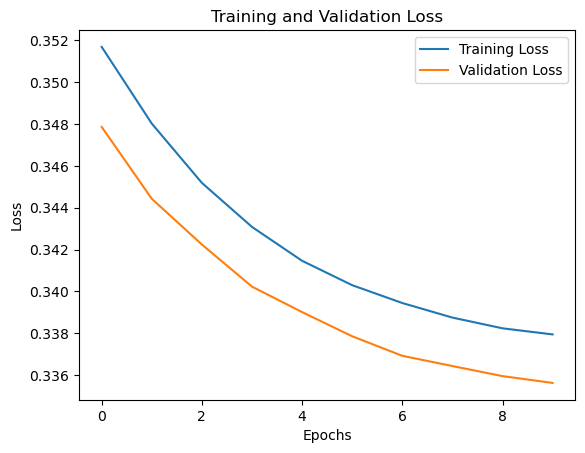

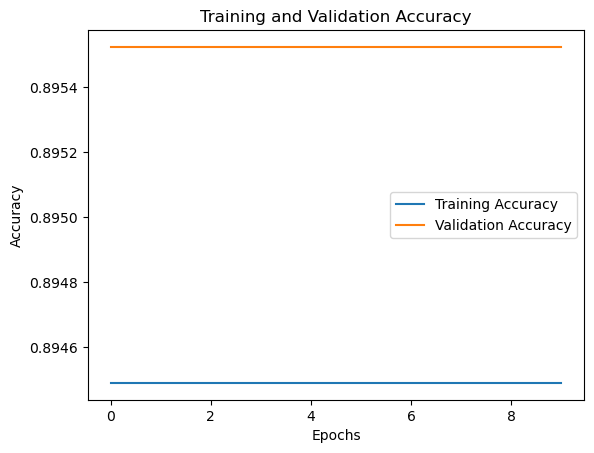

In [10]:
import matplotlib.pyplot as plt

# Train the model with validation data
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_data=(X_test_padded, y_test))

# Check if loss and accuracy are tracked in the history
if 'loss' in history.history and 'val_loss' in history.history:
    # Visualize training loss and validation loss
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
else:
    print("Loss history not found in model's history.")

if 'accuracy' in history.history and 'val_accuracy' in history.history:
    # Visualize training accuracy and validation accuracy
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()
else:
    print("Accuracy history not found in model's history.")